In [1]:
import torch
import sys
from matplotlib import gridspec
from matplotlib import pyplot as plt
sys.path.append('src')
from score_util_pub import *
from inference import *
import json

/home/jiyeon/anaconda3/envs/t2i_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For SDXL-Turbo

In [2]:
model = Generator('sdxl-turbo')

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


In [ ]:
seed = 3
prompt = 'a creative chair'
amplification_factor = [1.0]*7

# You can manually select amplification factor for each block 

amplification_factor[0] = 1.075 # amp factor for down 0 block
amplification_factor[1] = 1.15 # amp factor for down 1 block
amplification_factor[2] = 2.6 # amp factor for down 2 block
amplification_factor[3] = 2.8 # amp factor for middle block

# Or you can use the automatically found params
# Please note that the automatically found params are searched for each block 
# and needs to be further scaled to be used in combination.

file_path = f'./results/sdxl-turbo/chair/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)
amplification_factor[0] = 1+(data[0][0]-1)*0.3
amplification_factor[1] = 1+(data[0][1]-1)*0.3
amplification_factor[2] = 1+(data[0][2]-1)*0.2
amplification_factor[3] = 1+(data[0][3]-1)*0.2


In [12]:
orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor)

100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


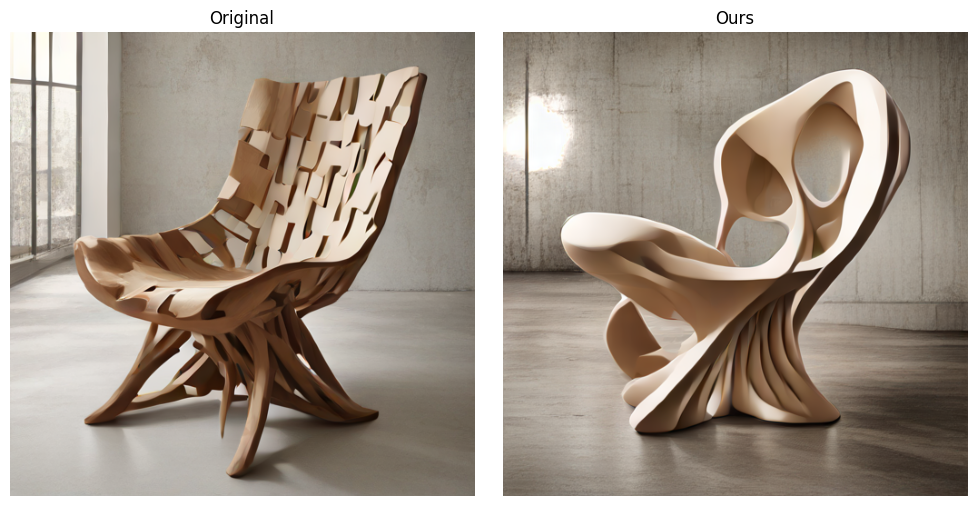

In [13]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()

----

## For SDXL-Lightning

In [2]:
model = Generator('sdxl-light-1')

/home/jiyeon/models/C3/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


In [3]:
seed = 42
prompt = 'a creative house'
amplification_factor = [1.0]*7

# You can manually select amplification factor for each block 

amplification_factor[0] = 1.1 # amp factor for down 0 block
amplification_factor[1] = 1.3 # amp factor for down 1 block
amplification_factor[2] = 1.6 # amp factor for down 2 block
amplification_factor[3] = 1.8 # amp factor for middle block

# Or you can use the automatically found params
# Please note that the automatically found params are searched for each block 
# and needs to be further scaled to be used in combination.

file_path = f'./results/sdxl-light-1/house/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)
amplification_factor[0] = 1+(data[0][0]-1)*0.2
amplification_factor[1] = 1+(data[0][1]-1)*0.2
amplification_factor[2] = 1+(data[0][2]-1)*0.1
amplification_factor[3] = 1+(data[0][3]-1)*0.1


In [4]:
orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0])

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


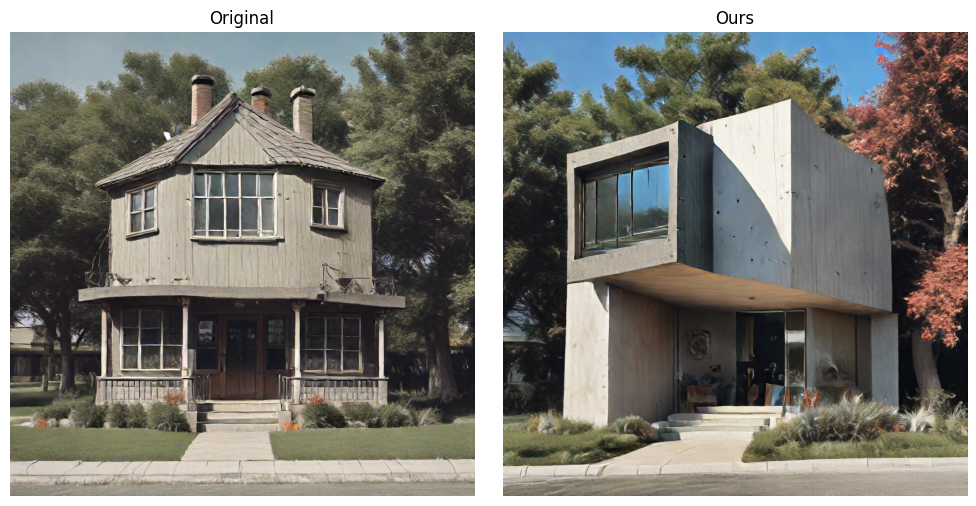

In [5]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()